# MultiTask Classification
---

## Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
plt.rcParams["figure.figsize"] = 12, 8

from config.config import *
# Module
import os
import sys
import pickle
import datetime

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import pandas as pd
import math
import sklearn.preprocessing as sk
from tensorboardX import SummaryWriter
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import random


# 関数のインポート
from data_loading import data_loading
from rm_abnormal_data import rm_abnormal_data_NPS
from preprocessing import preprocessing_X, preprocessing_y
from select_columns import select_columns
from make_dataset import make_dataset_train
from utils.sampling import over_and_under_sampling_NPS, resampling
from utils.get_params import get_params
from utils.modeling_gbdt import modeling_clf, estimate_model_dmatrix
from utils.get_logger import get_logger
from utils.graphing import plt_feature_importance
from impute_missing_values import impute_missing_values
from pathlib import Path
import japanize_matplotlib
plt.rcParams["figure.figsize"] = 12, 8

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from utils.graphing import plt_gain_chart, plt_roc_curve

np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

from tqdm import tqdm_notebook as tqdm

from multitask import make_circle_dataset, make_square_dataset

# Loggerの設定
from utils.get_logger import get_logger
log_time = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
filename = os.path.basename(Path().resolve()).split(".")[0]
log_filename = f"{filename}_{log_time}.log"
logfile_path = os.path.join(LOG_PATH, log_filename)
logger = get_logger(logfile_path)

/Users/fukasawat78/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [ ]:
target_list = [
    #"_IS_VERY_COST_CONSCIOUS",
    #"_IS_VERY_FAMILIER_WITH_SMARTPHONES",
    "_IS_A_NPS_DETRACTOR"
]

# データ読み込み
df_X, df_X_val, df_y = data_loading(phase="train", logger=logger)

# 欠損値処理
df_X = impute_missing_values(df_X, logger=logger)

# データ前処理（説明変数）
df_X = preprocessing_X(df_X, logger)

# 特徴量エンジニアリング
df_X_model, df_y_model = make_dataset_train(df_X, df_y, "dummy", logger)

X_train, X_valid, X_test = {}, {}, {}
y_train, y_valid, y_test = {}, {}, {}

for target in tqdm(target_list):
    
    sampling_method = "IMBLEARN"
    
    # 特徴量選択アルゴリズムで選択された特徴量だけ選択
    df_X_model_  = select_columns(df_X_model, target, logger)

    X_train_valid, X_test_, y_train_valid, y_test_ = train_test_split(df_X_model_, df_y_model[target], test_size=0.1, random_state=SEED)
    
    if sampling_method == "NONE":
        X_train_, X_valid_, y_train_, y_valid_ = train_test_split(X_train_valid, y_train_valid[target], test_size=0.2, random_state=SEED)

    elif sampling_method == "ORIGINAL":
        n_level = df_y_model[target].nunique()
        df_X, series_y = over_and_under_sampling_NPS(X_train_valid, y_train_valid, target, SEED, logger)
        X_train_, X_valid_, y_train_, y_valid_ = train_test_split(df_X, series_y[target], test_size=0.2, random_state=SEED)

    elif sampling_method == "IMBLEARN":
        n_level = df_y_model[target].nunique()
        df_X, series_y = resampling(X_train_valid, y_train_valid, target, SEED, logger)
        X_train_, X_valid_, y_train_, y_valid_ = train_test_split(df_X, series_y[target], test_size=0.2, random_state=SEED)
    
    X_train[target] = X_train_.values
    X_valid[target] = X_valid_.values
    X_test[target] = X_test_.values

    y_train[target] = y_train_.values
    y_valid[target] = y_valid_.values
    y_test[target] = y_test_.values
    
from snorkel.classification import DictDataset, DictDataLoader

dataloaders = []
for task_name in target_list:
    for split, X, Y in (
        ("train", X_train, y_train),
        ("valid", X_valid, y_valid),
        ("test", X_test, y_test),
    ):
        X_dict = {f"{task_name}_data": torch.FloatTensor(X[task_name])}
        Y_dict = {f"{task_name}_task": torch.LongTensor(Y[task_name])}
        dataset = DictDataset(f"{task_name}Dataset", split, X_dict, Y_dict)
        dataloader = DictDataLoader(dataset, batch_size=32)
        dataloaders.append(dataloader)

[2020-12-23 12:42:05,811][data_loading.py][data_loading][INFO]Start data loading
/Users/fukasawat78/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (34,37,39,40,46,51,56) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(max_iter=100)

clf.fit(X_train_, y_train_)
clf.score(X_train_, y_train_)
y_pred = clf.predict(X_test_)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score

confusion_mat = confusion_matrix(y_test_, y_pred)
acc_score = accuracy_score(y_test_, y_pred)
auc_score = roc_auc_score(y_test_, y_pred)
print(confusion_mat)
print(acc_score)
print(auc_score)

[[5799 1968]
 [1396  600]]
0.6554337806002254
0.5236107595647069


## Define Model

In [16]:
import torch.nn as nn
from snorkel.classification import Operation

input_dim = df_X_model_.shape[1]
output_dim = df_y_model[target].nunique()

# Define a two-layer MLP module and a one-layer prediction "head" module
base_mlp = nn.Sequential(nn.Linear(input_dim, 64), nn.ReLU(), nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, 16), nn.ReLU())
head_module = nn.Linear(16, output_dim)

# The module pool contains all the modules this task uses
module_pool = nn.ModuleDict({"base_mlp": base_mlp, "_IS_A_NPS_DETRACTOR_head_module": head_module})

# "From the input dictionary, pull out 'circle_data' and send it through input_module"
op1 = Operation(
    name="base_mlp", module_name="base_mlp", inputs=[("_input_", "_IS_A_NPS_DETRACTOR_data")]
)

# "Pass the output of op1 (the MLP module) as input to the head_module"
op2 = Operation(
    name="_IS_A_NPS_DETRACTOR_head", module_name="_IS_A_NPS_DETRACTOR_head_module", inputs=["base_mlp"]
)

op_sequence = [op1, op2]

from functools import partial

import torch.nn.functional as F

from snorkel.analysis import Scorer
from snorkel.classification import Task

detractor_task = Task(
    name="_IS_A_NPS_DETRACTOR_task",
    module_pool=module_pool,
    op_sequence=op_sequence,
    loss_func=F.cross_entropy,
    output_func=partial(F.softmax, dim=1),
    scorer=Scorer(metrics=["f1"]),
)

familier_with_smartphones_task = Task(
    name="_IS_VERY_FAMILIER_WITH_SMARTPHONES_task",
    module_pool=nn.ModuleDict({"base_mlp": base_mlp, "_IS_VERY_FAMILIER_WITH_SMARTPHONES_head": nn.Linear(16, output_dim)}),
    op_sequence=[
        Operation("base_mlp", [("_input_", "_IS_VERY_FAMILIER_WITH_SMARTPHONES_data")]),
        Operation("_IS_VERY_FAMILIER_WITH_SMARTPHONES_head", ["base_mlp"]),
    ],
    scorer=Scorer(metrics=["roc_auc"])
)

cost_conscious_task = Task(
    name="_IS_VERY_COST_CONSCIOUS_task",
    module_pool=nn.ModuleDict({"base_mlp": base_mlp, "_IS_VERY_COST_CONSCIOUS_head": nn.Linear(16, output_dim)}),
    op_sequence=[
        Operation("base_mlp", [("_input_", "_IS_VERY_COST_CONSCIOUS_data")]),
        Operation("_IS_VERY_COST_CONSCIOUS_head", ["base_mlp"]),
    ],
    scorer=Scorer(metrics=["roc_auc"])
)

## Model Estimation

In [18]:
from snorkel.classification import MultitaskClassifier

model = MultitaskClassifier([
    detractor_task, 
    #familier_with_smartphones_task,
    #cost_conscious_task
])

from snorkel.classification import Trainer

trainer_config = {
    "progress_bar": True, 
    "n_epochs": 10, 
    "lr": 0.001}

trainer = Trainer(**trainer_config)
trainer.fit(model, dataloaders)
model.score(dataloaders)

Epoch 9:: 100%|██████████| 3602/3602 [00:07<00:00, 504.59it/s, model/all/train/loss=0.693, model/all/train/lr=0.001, _IS_A_NPS_DETRACTOR_task/_IS_A_NPS_DETRACTORDataset/valid/f1=0]


{'_IS_A_NPS_DETRACTOR_task/_IS_A_NPS_DETRACTORDataset/train/f1': 0.6663836010662137,
 '_IS_A_NPS_DETRACTOR_task/_IS_A_NPS_DETRACTORDataset/valid/f1': 0.6677975685609273,
 '_IS_A_NPS_DETRACTOR_task/_IS_A_NPS_DETRACTORDataset/test/f1': 0.33934342575267906}

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score

pred = model.predict(dataloaders[2])

acc_score = accuracy_score(y_test_, np.argmax(pred["probs"]['_IS_A_NPS_DETRACTOR_task'], 1))
auc_score = roc_auc_score(y_test_, np.argmax(pred["probs"]['_IS_A_NPS_DETRACTOR_task'], 1))
print(acc_score)
print(auc_score)

## Add Task

In [25]:
from model.multitask import make_inv_circle_dataset

# We flip the inequality when generating the labels so that our positive
# class is now _outside_ the circle.
inv_circle_train, inv_circle_valid, inv_circle_test = make_inv_circle_dataset(N, R)
(X_train["inv_circle"], Y_train["inv_circle"]) = inv_circle_train
(X_valid["inv_circle"], Y_valid["inv_circle"]) = inv_circle_valid
(X_test["inv_circle"], Y_test["inv_circle"]) = inv_circle_test

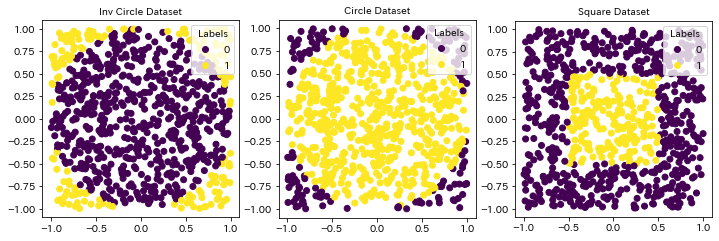

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3)

scatter = axs[0].scatter(
    X_train["inv_circle"][:, 0], X_train["inv_circle"][:, 1], c=Y_train["inv_circle"]
)
axs[0].set_aspect("equal", "box")
axs[0].set_title("Inv Circle Dataset", fontsize=10)
axs[0].legend(*scatter.legend_elements(), loc="upper right", title="Labels")

scatter = axs[1].scatter(
    X_train["circle"][:, 0], X_train["circle"][:, 1], c=Y_train["circle"]
)
axs[1].set_aspect("equal", "box")
axs[1].set_title("Circle Dataset", fontsize=10)
axs[1].legend(*scatter.legend_elements(), loc="upper right", title="Labels")

scatter = axs[2].scatter(
    X_train["square"][:, 0], X_train["square"][:, 1], c=Y_train["square"]
)
axs[2].set_aspect("equal", "box")
axs[2].set_title("Square Dataset", fontsize=10)
axs[2].legend(*scatter.legend_elements(), loc="upper right", title="Labels")


plt.show()

## Create the DictDataLoader

In [27]:
X_dict = {}  # Filled in by you
Y_dict = {}  # Filled in by you
inv_dataset = DictDataset("InvCircleDataset", "train", X_dict, Y_dict)
inv_dataloader = DictDataLoader(dataset=inv_dataset, batch_size=32)

In [30]:
all_dataloaders = dataloaders + [inv_dataloader]

In [31]:
inv_circle_task = Task(
    name="inv_circle_task",  # Filled in by you
    module_pool=nn.ModuleDict({"base_mlp": base_mlp, "square_head": nn.Linear(4, 2)}),
    op_sequence=[
        Operation("base_mlp", [("_input_", "inv_circle_data")]),
        Operation("square_head", ["base_mlp"]),
    ],
)

In [32]:
# Add your new task to the list of tasks for creating the MTL model
model = MultitaskClassifier([circle_task, square_task, inv_circle_task])  # Filled in by you

## Train & Validate

In [33]:
trainer.fit(model, all_dataloaders)
model.score(all_dataloaders)

{'circle_task/circleDataset/train/accuracy': 0.96,
 'circle_task/circleDataset/valid/accuracy': 0.94,
 'circle_task/circleDataset/test/accuracy': 0.93,
 'square_task/squareDataset/train/accuracy': 0.94375,
 'square_task/squareDataset/valid/accuracy': 0.96,
 'square_task/squareDataset/test/accuracy': 0.98}